In [1]:
#!pip install seaborn

In [2]:
import sys
import random
import inspect
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

In [3]:
model_path = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained(model_path, trust_remote_code=True)
max_length = tokenizer.model_max_length

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [4]:
def random_generate_sequences(minl, maxl=0, samples=1, with_N=False, padding_size=0, gc=0, seed=None):
    sequences = []
    basemap = ["A", "C", "G", "T"]
    if with_N:
        basemap.append("N")
    baseidx = len(basemap) - 1
    if seed:
        random.seed(seed)
    if maxl:
        for i in range(samples):
            length = random.randint(minl, maxl)
            if padding_size:
                length = (length // padding_size + 1) * padding_size if length % padding_size else length
                if length > maxl:
                    length -= padding_size
            seq = "".join([basemap[random.randint(0,baseidx)] for _ in range(length)])
            sequences.append(seq)
    else:
        for i in range(samples):
            seq = "".join([basemap[random.randint(0,baseidx)] for _ in range(minl)])
            sequences.append(seq)
    
    return sequences

In [5]:
# sequences = ["ATTCCGATTCCGATTCCG", "ATTTCTCTCTCTCTCTGAGATCGATCGATCGAT"]
sequences = random_generate_sequences(30, 500, 100, padding_size=6)
sequences[:10]

['AATCTCTGTCGACAGTTCTCGAGCTCTAGCGAGTTCCCTGATCTGGAAGTAGCGACAATCTTCCGGGTCTCATCTTTTCAAACTCGTGATCGTTGTTGGGGTCTGTGATTAGGGATGGAACCTCATACCTGCGCGTCGGTGTGTGACCTTCAATAGCTGGGAAGGCCGGTAAGGGTCTATGAGAATATATGTGTACTACGGAGAGTCGGCCACTGGTCGAGGCGACAATAATTGGGCCCTAGGATCACGACAGATCTCGTAAATAGCAGCAGAGTTACCAGGCCCATGACGTGATCCGCGTAGAAGATGATACCCGTGAATTAGGTGTTACTCTTA',
 'CGAGTTTCGTATGGTAACCATCACGGGCTTAATTACCCGCAGCGCATAGTACCGTCTACCGTGACTCTAAGCACGGGTCCCCGCTTTACTATTGCCTCAGCGATTTGCACCCTGGGATGAGCCATATTACGGCAACTTGGGTCGGCAAGTATGTTCAATAGCGTACTCCTTCACTCAGTGATTGCTATGTCCAACGTGCATTTTGTCGCGGAGAGAGTCGTACAGAATTCTCGA',
 'TTTGAATCTTTTATCCCTCTATTGCGCTTTAAATTGTAAGGATATTCCGTCAGACTCCCAAACATAGGCTCGATGCTGAGGTAGATTGTCATTATCTATCTTACGCAATGGTTAACCATGAGCAGTTTACTCTACGAA',
 'TAGTCCCACATGCGAACATGACCCGCAGTGCGATGAGCGAGTGCTGCATGTGTCGTAAATGGAAATAAAGTGGCCTCGGCTGAGCATTAAAATGCTCAACCCAGGGTGCCTACGCTAAAATCCGAACAGCGAAGAATTACGTCGTCGCCG',
 'CCATCAGAGGGAGCAAGTGGGCACAGACCACTAATTTCGTCGAATTCCGGCTCATATATGGGGATACCAGTCGCTCTTCGTGCCCATCATTATTTGCTTAGAGACTTTTCGACTGTCTCG

In [6]:
inputs = tokenizer(
    sequences,
    truncation=True, padding='longest',
    max_length=max_length,
    return_tensors="pt"
)
tokens_ids = inputs['input_ids'].detach()
tokens_str = [b.split() for b in tokenizer.batch_decode(tokens_ids)]
tokens_idx = [[False if s in tokenizer.all_special_tokens else True for i, s in enumerate(tokens)] for tokens in tokens_str]

In [7]:
# Predict
sig = inspect.signature(model.forward)
params = sig.parameters
if "output_attentions" in params:
    outputs = model(
        **inputs,
        output_attentions=True,
        output_hidden_states=True
    )
else:
    outputs = model(
        **inputs,
        output_hidden_states=True
    )

## Attention Map

In [8]:
def plot_attention_map(attentions, tokens_str, tokens_idx, layer=-1, idx=0, ncols=3, scale_width=5, scale_height=4):
    tokens = [tokens_str[idx][i] for i,b in enumerate(tokens_idx[idx]) if b]
    n_heads = len(attentions)
    nrows = (n_heads + ncols - 1) // ncols
    figsize = (ncols * scale_width, nrows * scale_height)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if n_heads == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    for i, data in enumerate(attentions):
        data = data[layer][idx].detach().numpy()
        data = [[data[j][jj] for jj,bb in enumerate(tokens_idx[idx]) if bb]
                             for j,b in enumerate(tokens_idx[idx]) if b]
        sns.heatmap(
            data,
            ax=axes[i], cmap="viridis",
            xticklabels=tokens,
            yticklabels=tokens
        )
        axes[i].set_title(f"Head {i+1}")
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

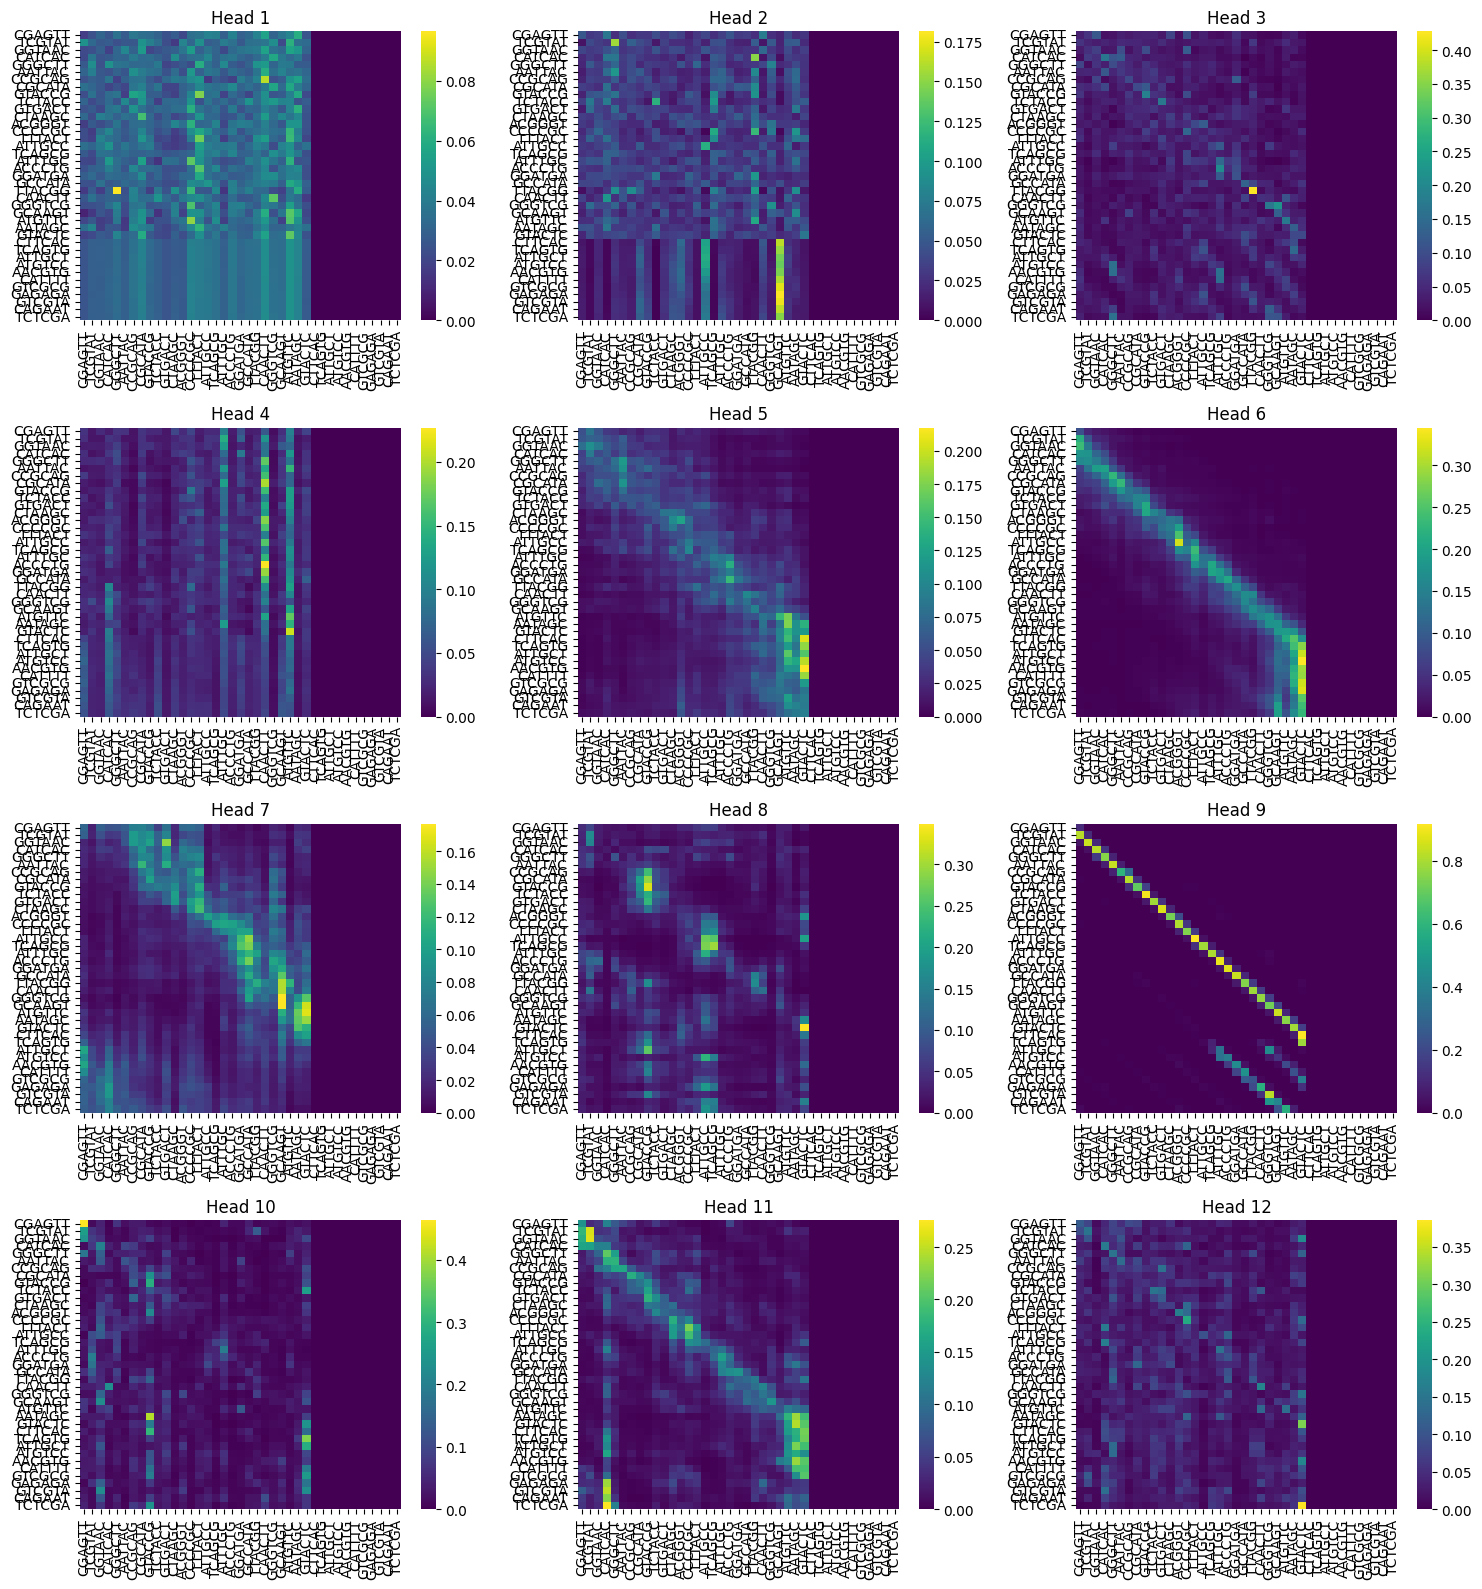

In [9]:
# Attention map
if hasattr(outputs, 'attentions'):
    attentions = outputs.attentions  # ((seq_num, heads, max_token_len, max_token_len) x layers)
    plot_attention_map(attentions, tokens_str, tokens_idx, layer=-1, idx=1, ncols=3)

## Embedding visualization

In [10]:
def plot_layer_embeddings(hidden_states, attention_mask, layers=[0,1], labels=None, reducer="t-SNE", ncols=4, scale_width=5, scale_height=4):
    if reducer.lower() == "pca":
        dim_reducer = PCA(n_components=2)
    elif reducer.lower() == "t-sne":
        dim_reducer = TSNE(n_components=2)
    elif reducer.lower() == "umap":
        dim_reducer = UMAP(n_components=2)
    else:
        raise("Unsupported dim reducer, please try PCA, t-SNE or UMAP.")
    n_layers = len(layers)
    nrows = (n_layers + ncols - 1) // ncols
    figsize = (ncols * scale_width, nrows * scale_height)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if n_layers == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    for i,layer_i in enumerate(layers):
        embeddings = hidden_states[layer_i].detach().numpy()
        mean_sequence_embeddings = torch.sum(attention_mask*embeddings, axis=-2) / torch.sum(attention_mask, axis=1)
        layer_dim_reduced_vectors = dim_reducer.fit_transform(mean_sequence_embeddings.detach().numpy())
        if not labels:
            labels = ["Uncategorized"] * layer_dim_reduced_vectors.shape[0]
        dataframe = {
            'Dimension 1': layer_dim_reduced_vectors[:,0],
            'Dimension 2': layer_dim_reduced_vectors[:,1],
            'labels': labels
            }
        df = pd.DataFrame.from_dict(dataframe)
        sns.scatterplot(
            data=df,
            x='Dimension 1',
            y='Dimension 2',
            hue='labels', ax=axes[i]
        )
        axes[i].set_title(f"Layer {layer_i+1}")
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

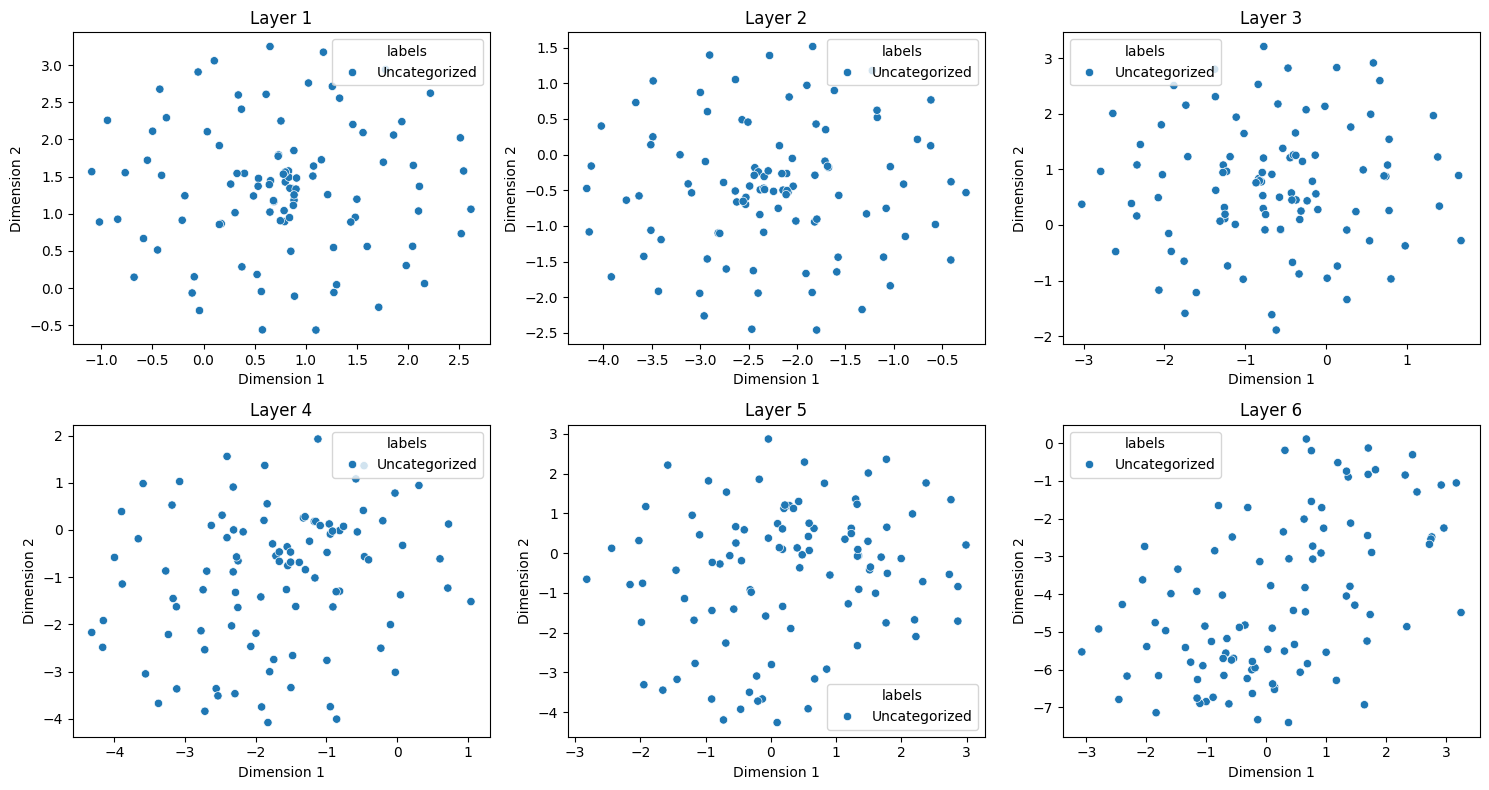

In [11]:
# Get the layer embeddings
hidden_states = outputs['hidden_states']
attention_mask = torch.unsqueeze(torch.tensor(tokens_idx), dim=-1)

plot_layer_embeddings(hidden_states, attention_mask, layers=range(6), labels=None, reducer="t-SNE", ncols=3)

## Probability of token

In [12]:
def get_token_probability(probabilities, idx=0, top_k=5):
    tokens_probs = []
    probas = probabilities[idx]
    for pos, probs in enumerate(probas):
        sorted_positions = np.argsort(-probs)
        sorted_probs = probs[sorted_positions]
        token_probs = {}
        for k in range(top_k):
            predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
            prob = sorted_probs[k]
            # print(f"seq_id: {idx}, token_position: {pos}, k: {k}, token: {predicted_token}, probability: {prob * 100:.2f}%")
            token_probs[predicted_token] = prob
        tokens_probs.append(token_probs)
    return tokens_probs

In [13]:
logits = outputs['logits'].detach().numpy()
probabilities = []
# get probabilities separately for each seq as they have different lengths
for idx in range(logits.shape[0]):
    logits_seq = logits[idx]
    logits_seq = [logits_seq[i] for i,b in enumerate(tokens_idx[idx]) if b]
    probs = softmax(logits_seq, axis=-1)  # use softmax to transform logits into probabilities
    probabilities.append(probs)

tokens_probs = get_token_probability(probabilities, idx=1, top_k=5)
tokens_probs

[{'CGAGTT': 0.17259638,
  'ATTTTG': 0.074336775,
  'AATTTT': 0.03158132,
  'ACTTTG': 0.029733788,
  'ACTTTT': 0.027789203},
 {'TCGTAT': 0.9961033,
  'CCGTAT': 0.002380367,
  'TTGTAT': 0.00013929073,
  'TCGCAT': 0.00012747609,
  'TCATAT': 8.166215e-05},
 {'GGTAAC': 0.99959,
  'GGTAAT': 0.00017227474,
  'GGGTAA': 2.4163122e-05,
  'GGTAAA': 2.2399232e-05,
  'TGGTAA': 2.146018e-05},
 {'CATCAC': 0.97606814,
  'ATCCCC': 0.005534643,
  'ATCACC': 0.0022881867,
  'CGTCAC': 0.0019009738,
  'ATTCCC': 0.0010483828},
 {'GGGCTT': 0.99871385,
  'GGACTT': 0.0001330908,
  'GGGTTT': 0.000121900695,
  'AGGCTT': 0.00011995096,
  'CGGGTT': 7.997676e-05},
 {'AATTAC': 0.9997267,
  'GATTAC': 4.0375737e-05,
  'ACTTAC': 2.550763e-05,
  'ATTTAC': 1.6145128e-05,
  'AACTAC': 1.5840844e-05},
 {'CCGCAG': 0.999956,
  'CCGCAC': 1.18452435e-05,
  'CCACAG': 6.178044e-06,
  'CTGCAG': 3.992571e-06,
  'CCGCGG': 3.4355671e-06},
 {'CGCATA': 0.99955136,
  'TGCATA': 0.00012145034,
  'AGCGTA': 4.034968e-05,
  'AGCATA': 3.702666